1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Original prediction: cat (0.9947)
True label:          cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

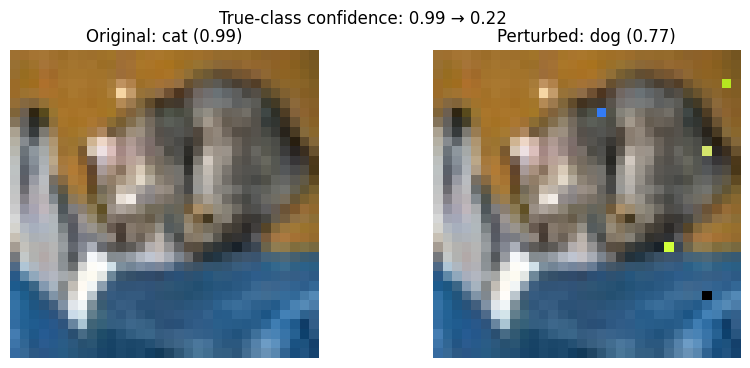

In [2]:
# -- coding: utf-8 --
"""
Untargeted CIFAR-10 adversarial attack via Differential Evolution (best1bin)
"""

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import load_model

# ---- 1) Load data and model ----
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

x_test = x_test.astype('float32') / 255.0
model = load_model('resnet_cifar10_best.h5')

# ---- 2) Pick an image to attack ----
img_index    = 0
original_img = x_test[img_index]
true_label   = int(y_test[img_index][0])
orig_pred    = model.predict(original_img[None])[0]
orig_class   = np.argmax(orig_pred)

print(f"Original prediction: {class_names[orig_class]} ({orig_pred[orig_class]:.4f})")
print(f"True label:          {class_names[true_label]}")

# ---- 3) Perturbation helper ----
def perturb_image(vectors, img):
    """Apply one or many perturbation vectors of shape (5*num_pixels,) to img."""
    vs = np.atleast_2d(vectors).astype(int)
    out = np.tile(img, [len(vs),1,1,1])
    for i,v in enumerate(vs):
        pixels = np.split(v, len(v)//5)
        for (x,y,r,g,b) in pixels:
            out[i, x, y] = [r/255.0, g/255.0, b/255.0]
    return out

# ---- 4) Fitness: minimize confidence in the true class ----
def fitness(vec):
    pert = perturb_image(vec, original_img)[0]
    p = model.predict(pert[None])[0]
    return p[true_label]

# ---- 5) DE Solver (best1bin only) ----
class DifferentialEvolution:
    def __init__(self, func, bounds, popsize=10, maxiter=100, F=0.5, CR=0.7, seed=None):
        self.func = func
        self.bounds = np.array(bounds)  # shape (n_dims, 2)
        self.n_dim  = len(bounds)
        self.popsize = popsize
        self.maxiter = maxiter
        self.F = F
        self.CR = CR
        self.rng = np.random.RandomState(seed)
        # initialize population uniformly within bounds
        low, high = self.bounds[:,0], self.bounds[:,1]
        self.pop = low + self.rng.rand(popsize, self.n_dim)*(high-low)
        self.pop_f = np.array([self.func(ind) for ind in self.pop])

    def solve(self):
        low, high = self.bounds[:,0], self.bounds[:,1]
        for gen in range(self.maxiter):
            best_idx = np.argmin(self.pop_f)
            best     = self.pop[best_idx]
            for i in range(self.popsize):
                # --- Mutation (best1) ---
                idxs = [idx for idx in range(self.popsize) if idx!=i and idx!=best_idx]
                r0, r1 = self.rng.choice(idxs, 2, replace=False)
                mutant = best + self.F*(self.pop[r0]-self.pop[r1])
                # --- Crossover (binomial) ---
                trial = self.pop[i].copy()
                jrand = self.rng.randint(self.n_dim)
                for j in range(self.n_dim):
                    if self.rng.rand() < self.CR or j==jrand:
                        trial[j] = mutant[j]
                # --- Enforce bounds ---
                trial = np.minimum(np.maximum(trial, low), high)
                # --- Selection ---
                f_trial = self.func(trial)
                if f_trial < self.pop_f[i]:
                    self.pop[i]   = trial
                    self.pop_f[i] = f_trial
            # optional: early stopping?
            if np.std(self.pop_f)/ (np.abs(np.mean(self.pop_f))+1e-12) < 1e-6:
                break
        best_idx = np.argmin(self.pop_f)
        return self.pop[best_idx], self.pop_f[best_idx]

# ---- 6) Set up DE and run ----
num_pixels = 5
# build bounds list: [(x,y,R,G,B), ...] for each pixel
bounds = [(0,31),(0,31),(0,255),(0,255),(0,255)] * num_pixels

de = DifferentialEvolution(
    func=fitness,
    bounds=bounds,
    popsize=20,
    maxiter=200,
    F=0.5,
    CR=0.7,
    seed=42
)

best_vec, best_score = de.solve()
print(f"DE finished — confidence in true class: {best_score:.4f}")

# ---- 7) Apply best perturbation and visualize ----
perturbed = perturb_image(best_vec, original_img)[0]
pert_pred = model.predict(perturbed[None])[0]
pert_class = np.argmax(pert_pred)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title(f"Original: {class_names[orig_class]} ({orig_pred[orig_class]:.2f})")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(perturbed)
plt.title(f"Perturbed: {class_names[pert_class]} ({pert_pred[pert_class]:.2f})")
plt.axis('off')

plt.suptitle(f"True‑class confidence: {orig_pred[true_label]:.2f} → {pert_pred[true_label]:.2f}")
plt.show()

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import classification_report


# GPU Check and Memory Growth Setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detected: {[gpu.name for gpu in gpus]}")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("No GPU detected. Training will use CPU.")


def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    """
    A standard ResNet basic block with two convolutions and a skip connection.
    """
    shortcut = x

    # First convolution
    x = layers.Conv2D(filters,
                      kernel_size=kernel_size,
                      strides=stride,
                      padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Second convolution
    x = layers.Conv2D(filters,
                      kernel_size=kernel_size,
                      strides=1,
                      padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if conv_shortcut:
        shortcut = layers.Conv2D(filters,
                                 kernel_size=1,
                                 strides=stride,
                                 padding="same",
                                 kernel_regularizer=regularizers.l2(1e-4))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x


def build_resnet_cifar(input_shape=(32, 32, 3), num_classes=10, num_blocks=[2, 2, 2], initial_filters=16):
    """
    Builds a small ResNet for CIFAR-10 (e.g., ResNet-20 if num_blocks=[3,3,3]).
    You can customize num_blocks to change depth.
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(initial_filters,
                      kernel_size=3,
                      strides=1,
                      padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    filters = initial_filters
    # Stacking residual blocks
    for stage, blocks in enumerate(num_blocks):
        for block in range(blocks):
            stride = 1
            conv_shortcut = False
            # Downsample at the first block of each stage (except the first)
            if stage > 0 and block == 0:
                stride = 2
                conv_shortcut = True
            x = residual_block(x, filters, stride=stride, conv_shortcut=conv_shortcut)
        filters *= 2

    # Final layers
    x = layers.AveragePooling2D(pool_size=8)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="ResNet_CIFAR")
    return model


if __name__ == "__main__":
    # Hyperparameters
    batch_size = 64
    epochs = 50
    input_shape = (32, 32, 3)
    num_classes = 10

    # Load CIFAR-10 data
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    # Build and compile the model
    model = build_resnet_cifar(input_shape=input_shape,
                               num_classes=num_classes,
                               num_blocks=[2, 2, 2],  # Total depth = 6n+2 = 14
                               initial_filters=16)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"]);

    model.summary()

    # Callbacks
    checkpoint = ModelCheckpoint("resnet_cifar10_best.h5",
                                 monitor="val_accuracy",
                                 save_best_only=True,
                                 verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=5,
                                  verbose=1,
                                  min_lr=1e-6)

    # Training
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        shuffle=True,
        callbacks=[checkpoint, reduce_lr]
    )

    # Load best weights and evaluate
    model.load_weights("resnet_cifar10_best.h5")
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Detailed classification report
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Export the entire model
    model.save("resnet_cifar10.h5")
    print("Model exported to resnet_cifar10.h5")


GPU setup error: Physical devices cannot be modified after being initialized


Model: "ResNet_CIFAR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │        448 │ input_layer_7[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_13[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_14[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ activation_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 32, 32,    │          0 │ add_6[0][0]       │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_15[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_16[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 176,938 (691.16 KB)

 Trainable params: 175,818 (686.79 KB)

 Non-trainable params: 1,120 (4.38 KB)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4295 - loss: 1.6118
Epoch 1: val_accuracy improved from -inf to 0.56860, saving model to resnet_cifar10_best.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.4297 - loss: 1.6114 - val_accuracy: 0.5686 - val_loss: 1.2974 - learning_rate: 0.0010
Epoch 2/50
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6562 - loss: 1.0170
Epoch 2: val_accuracy improved from 0.56860 to 0.58140, saving model to resnet_cifar10_best.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.6563 - loss: 1.0169 - val_accuracy: 0.5814 - val_loss: 1.2732 - learning_rate: 0.0010
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7220 - loss: 0.8541
Epoch 3: val_accuracy improved from 0.58140 to 0.61700, saving model to resnet_cifar10_best.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7220 - loss: 0.8540 - val_accuracy: 0.6170 - val_loss: 1.1884 - learning_rate: 0.0010
Epoch 4/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7655 - loss: 0.7334
Epoch 4: val_accuracy improved from 0.61700 to 0.67880, saving model to resnet_cifar10_best.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7656 - loss: 0.7334 - val_accuracy: 0.6788 - val_loss: 1.0782 - learning_rate: 0.0010
Epoch 5/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7991 - loss: 0.6527
Epoch 5: val_accuracy improved from 0.67880 to 0.69880, saving model to resnet_cifar10_best.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7991 - loss: 0.6527 - val_accuracy: 0.6988 - val_loss: 0.9519 - learning_rate: 0.0010
Epoch 6/50
700/704 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8181 - loss: 0.6044
Epoch 6: val_accuracy improved from 0.69880 to 0.71400, saving model to resnet_cifar10_best.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8181 - loss: 0.6044 - val_accuracy: 0.7140 - val_loss: 1.0408 - learning_rate: 0.0010
Epoch 7/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8415 - loss: 0.5417
Epoch 7: val_accuracy did not improve from 0.71400
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8415 - loss: 0.5418 - val_accuracy: 0.6958 - val_loss: 1.0668 - learning_rate: 0.0010
Epoch 8/50
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8571 - loss: 0.5027
Epoch 8: val_accuracy improved from 0.71400 to 0.73000, saving model to resnet_cifar10_best.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8571 - loss: 0.5028 - val_accuracy: 0.7300 - val_loss: 0.9389 - learning_rate: 0.0010
Epoch 9/50
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8738 - loss: 0.4574
Epoch 9: val_accuracy did not improve from 0.73000
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8738 - loss: 0.4575 - val_accuracy: 0.6942 - val_loss: 1.1632 - learning_rate: 0.0010
Epoch 10/50
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8820 - loss: 0.4327
Epoch 10: val_accuracy did not improve from 0.73000
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8820 - loss: 0.4328 - val_accuracy: 0.6978 - val_loss: 1.2365 - learning_rate: 0.0010
Epoch 11/50
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8911 - loss: 0.4172
Epoch 11: val_accuracy improved from 0.73000 to 0.73100, saving model to resnet_cifar10_best.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8911 - loss: 0.4173 - val_accuracy: 0.7310 - val_loss: 0.9839 - learning_rate: 0.0010
Epoch 12/50
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9033 - loss: 0.3900
Epoch 12: val_accuracy improved from 0.73100 to 0.74420, saving model to resnet_cifar10_best.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9033 - loss: 0.3900 - val_accuracy: 0.7442 - val_loss: 1.0303 - learning_rate: 0.0010
Epoch 13/50
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9164 - loss: 0.3560
Epoch 13: val_accuracy did not improve from 0.74420

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9164 - loss: 0.3560 - val_accuracy: 0.7188 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 14/50
700/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9508 - loss: 0.2709
Epoch 14: val_accuracy improved from 0.74420 to 0.82580, saving model to resnet_cifar10_best.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9509 - loss: 0.2707 - val_accuracy: 0.8258 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 15/50
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9767 - loss: 0.2081
Epoch 15: val_accuracy did not improve from 0.82580
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9767 - loss: 0.2081 - val_accuracy: 0.8258 - val_loss: 0.7088 - learning_rate: 1.0000e-04
Epoch 16/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9840 - loss: 0.1919
Epoch 16: val_accuracy improved from 0.82580 to 0.83020, saving model to resnet_cifar10_best.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9840 - loss: 0.1919 - val_accuracy: 0.8302 - val_loss: 0.7201 - learning_rate: 1.0000e-04
Epoch 17/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9876 - loss: 0.1775
Epoch 17: val_accuracy did not improve from 0.83020
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9876 - loss: 0.1775 - val_accuracy: 0.8242 - val_loss: 0.7384 - learning_rate: 1.0000e-04
Epoch 18/50
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9909 - loss: 0.1667
Epoch 18: val_accuracy did not improve from 0.83020
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9909 - loss: 0.1667 - val_accuracy: 0.8232 - val_loss: 0.7732 - learning_rate: 1.0000e-04
Epoch 19/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9922 - loss: 0.1599
Epoch 19: val_accuracy did not improve from 0.83020

Epoch 19: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9922 -

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.93      0.89      0.91      1000
           2       0.78      0.71      0.75      1000
           3       0.65      0.68      0.66      1000
           4       0.76      0.84      0.80      1000
           5       0.78      0.71      0.74      1000
           6       0.82      0.87      0.84      1000
           7       0.88      0.84      0.86      1000
           8       0.91      0.89      0.90      1000
           9       0.87      0.89      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

Model exported to resnet_cifar10.h5
